In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from functools import reduce
import seaborn as sns
from esda.moran import Moran
from esda.geary import Geary
from esda.getisord import G, G_Local
from pysal.lib import weights
from splot.esda import moran_scatterplot
from libpysal.weights import DistanceBand
from libpysal.weights import KNN

In [4]:
przestepstwa = pd.read_csv("Przestepstwa_pow.csv")
pow = pd.read_csv("Przestepstwa_pow.csv")
bezrobotni = pd.read_csv("Bezrobotni.csv")
ceny = pd.read_csv("Ceny_mieszkan.csv")
dochody = pd.read_csv("Dochody_na_mieszkanca.csv")
wynagrodzenie = pd.read_csv("Przecietne_wynagrodzenie.csv")
rozwody = pd.read_csv("Rozwody_i_separacje.csv")
ludnosc = pd.read_csv("Ludnosc.csv")

In [5]:
pow_map = "powiaty.shp"
pow_m = gpd.read_file(pow_map)

In [6]:
(pow_m).head()


,gml_id,JPT_SJR_KO,JPT_POWIER,JPT_KOD_JE,JPT_NAZWA_,JPT_ORGAN_,JPT_JOR_ID,WERSJA_OD,WERSJA_DO,WAZNY_OD,...,JPT_ID,JPT_POWI_1,JPT_KJ_I_3,JPT_GEOMET,JPT_GEOM_1,SHAPE_LENG,SHAPE_AREA,REGON,RODZAJ,geometry
0,None,POW,92617,1807,powiat krośnieński,None,13415,20210128,0,20170101,...,1359583,0,None,0,0,3.11205337354,.12332626559,37044051900000,powiat,"POLYGON ((689863.285 218885.536, 689862.128 21..."
1,None,POW,141297,2804,powiat elbląski,None,13422,20210514,0,20120926,...,1360107,0,None,0,0,4.2521309989,.19417975633,17074769000000,powiat,"POLYGON ((551842.165 693417.652, 551870.912 69..."
2,None,POW,209827,1415,powiat ostrołęcki,None,13409,20210518,0,20120926,...,1360143,0,None,0,0,5.31641009622,.28125317026,55066883500000,powiat,"POLYGON ((646230.458 617154.258, 646336.602 61..."
3,None,POW,79097,0413,powiat sępoleński,None,13424,20220112,0,20120926,...,1362180,0,None,0,0,2.00313300009,.10690160786,09235092600000,powiat,"POLYGON ((384997.245 615178.269, 385170.687 61..."
4,None,POW,126576,3019,powiat pilski,None,13417,20220112,0,20120926,...,1362184,0,None,0,0,4.17134504707,.17008216429,57079948000000,powiat,"POLYGON ((342585.53 579834.38, 342632.859 5798..."


In [7]:
list = [przestepstwa, bezrobotni, ceny, dochody, wynagrodzenie, rozwody]

for i in list:
    i.drop(['oid', 'kod KTS', 'powierzchnia', 'rok', 'TERYT', 'Typ powiatu', 'TERYT województwa'], axis=1, inplace=True)

In [8]:
przestepstwa.rename(columns={
    'Przestępstwa stwierdzone przez Policję w zakończonych postępowaniach przygotowawczych|ogółem' : 'Przestepstwa'
}, inplace=True)
bezrobotni.rename(columns={
    'Bezrobotni zarejestrowani pozostający bez pracy dłużej niż 1 rok|ogółem' : 'Bezrobotni'
}, inplace=True)
ceny.rename(columns={
    'Średnia cena lokali mieszkalnych sprzedanych w ramach transakcji rynkowych|ogółem|ogółem' : 'Ceny mieszkan'
}, inplace=True)
dochody.rename(columns={
    'Dochody na 1 mieszkańca|gminy łącznie z miastami na prawach powiatu|ogółem' : 'Dochody na mieszkanca'
}, inplace=True)
wynagrodzenie.rename(columns={
    'Przeciętne miesięczne wynagrodzenia brutto|ogółem' : 'Wynagrodzenie'
}, inplace=True)
rozwody.rename(columns={
    'Rozwody i separacje|rozwody|ogółem' : 'Rozwody i separacje'
}, inplace=True)

In [9]:
ludnosc.columns = ludnosc.columns.str.strip()

ludnosc = pd.DataFrame({
    'powiat': ludnosc['Powiaty'],
    'Ludnosc_powiaty': ludnosc['Ludnosc']
})

print(ludnosc)

                powiat  Ludnosc_powiaty
0        bolesławiecki            90103
1       dzierżoniowski           100813
2            głogowski            89102
3             górowski            34870
4             jaworski            50116
..                 ...              ...
375         świdwiński            46724
376            wałecki            53039
377           Koszalin           107048
378           Szczecin           401907
379        Świnoujście            40888

[380 rows x 2 columns]


In [10]:
przestepstwa.head()

,powiat,Województwo,Przestepstwa
0,nowosądecki,małopolskie,11958.0
1,tarnowski,małopolskie,2860.0
2,gorzowski,lubuskie,1108.0
3,koniński,wielkopolskie,1163.0
4,poznański,wielkopolskie,5260.0


In [11]:
przestepstwa['powiat'] = przestepstwa['powiat'].str.strip()
ludnosc['powiat'] = ludnosc['powiat'].str.strip()

In [12]:
przestepstwa_merge = przestepstwa.merge(ludnosc, on='powiat')

In [13]:
przestepstwa_merge['Przestepstwa_średnia_powiaty'] = (przestepstwa_merge['Przestepstwa']/przestepstwa_merge['Ludnosc_powiaty'])

In [14]:
print(przestepstwa_merge[['powiat', 'Przestepstwa_średnia_powiaty']])

           powiat  Przestepstwa_średnia_powiaty
0     nowosądecki                      0.055158
1       tarnowski                      0.014194
2       gorzowski                      0.015424
3        koniński                      0.008943
4       poznański                      0.013174
..            ...                           ...
395     siedlecki                      0.009415
396    sokołowski                      0.017081
397     węgrowski                      0.012260
398  sochaczewski                      0.016685
399   żyrardowski                      0.021162

[400 rows x 2 columns]


In [15]:
bezrobotni.head()

,powiat,Województwo,Bezrobotni
0,nowosądecki,małopolskie,3256.0
1,tarnowski,małopolskie,2009.0
2,gorzowski,lubuskie,402.0
3,koniński,wielkopolskie,1928.0
4,poznański,wielkopolskie,913.0


In [16]:
bezrobotni['powiat'] = bezrobotni['powiat'].str.strip()
ludnosc['powiat'] = ludnosc['powiat'].str.strip()

In [17]:
bezrobotni_merge = bezrobotni.merge(ludnosc, on='powiat')

In [18]:
bezrobotni_merge['Bezrobotni_średnia_powiaty'] = (bezrobotni_merge['Bezrobotni']/bezrobotni_merge['Ludnosc_powiaty'])

In [19]:
print(bezrobotni_merge[['powiat', 'Bezrobotni_średnia_powiaty']])

           powiat  Bezrobotni_średnia_powiaty
0     nowosądecki                    0.015019
1       tarnowski                    0.009970
2       gorzowski                    0.005596
3        koniński                    0.014825
4       poznański                    0.002287
..            ...                         ...
395     siedlecki                    0.007190
396    sokołowski                    0.010613
397     węgrowski                    0.011987
398  sochaczewski                    0.006173
399   żyrardowski                    0.020462

[400 rows x 2 columns]


In [20]:
rozwody.head()

,powiat,Województwo,Rozwody i separacje
0,nowosądecki,małopolskie,139.0
1,tarnowski,małopolskie,175.0
2,gorzowski,lubuskie,72.0
3,koniński,wielkopolskie,142.0
4,poznański,wielkopolskie,427.0


In [21]:
rozwody['powiat'] = rozwody['powiat'].str.strip()

In [22]:
rozwody_merge = rozwody.merge(ludnosc, on='powiat')

In [23]:
rozwody_merge['Rozwody_średnia_powiaty'] = (rozwody_merge['Rozwody i separacje']/rozwody_merge['Ludnosc_powiaty'])

In [24]:
print(rozwody_merge[['powiat', 'Rozwody_średnia_powiaty']])

           powiat  Rozwody_średnia_powiaty
0     nowosądecki                 0.000641
1       tarnowski                 0.000868
2       gorzowski                 0.001002
3        koniński                 0.001092
4       poznański                 0.001069
..            ...                      ...
395     siedlecki                 0.001020
396    sokołowski                 0.000911
397     węgrowski                 0.000912
398  sochaczewski                 0.001329
399   żyrardowski                 0.001294

[400 rows x 2 columns]


In [25]:
files_to_merge = [przestepstwa_merge, bezrobotni_merge, ceny, dochody, wynagrodzenie, rozwody_merge]

stats =['powiat', 'Województwo']

merged = reduce(lambda left, right: left.merge(right, on=stats, how='inner'), files_to_merge)
merged.drop(['Przestepstwa', 'Ludnosc_powiaty_x', 'Bezrobotni', 'Ludnosc_powiaty_y', 'Rozwody i separacje', 'Ludnosc_powiaty'], axis=1, inplace=True)



print(merged)

           powiat    Województwo  Przestepstwa_średnia_powiaty  \
0     nowosądecki    małopolskie                      0.055158   
1       tarnowski    małopolskie                      0.014194   
2       gorzowski       lubuskie                      0.015424   
3        koniński  wielkopolskie                      0.008943   
4       poznański  wielkopolskie                      0.013174   
..            ...            ...                           ...   
515     siedlecki    mazowieckie                      0.009415   
516    sokołowski    mazowieckie                      0.017081   
517     węgrowski    mazowieckie                      0.012260   
518  sochaczewski    mazowieckie                      0.016685   
519   żyrardowski    mazowieckie                      0.021162   

     Bezrobotni_średnia_powiaty  Ceny mieszkan  Dochody na mieszkanca  \
0                      0.015019       242497.0                6290.69   
1                      0.009970       210957.0               

In [26]:
merged.columns

Index(['powiat', 'Województwo', 'Przestepstwa_średnia_powiaty',
       'Bezrobotni_średnia_powiaty', 'Ceny mieszkan', 'Dochody na mieszkanca',
       'Wynagrodzenie', 'Rozwody_średnia_powiaty'],
      dtype='object')

In [27]:
merged.head()

,powiat,Województwo,Przestepstwa_średnia_powiaty,Bezrobotni_średnia_powiaty,Ceny mieszkan,Dochody na mieszkanca,Wynagrodzenie,Rozwody_średnia_powiaty
0,nowosądecki,małopolskie,0.055158,0.015019,242497.0,6290.69,4160.76,0.000641
1,tarnowski,małopolskie,0.014194,0.009970,210957.0,5333.95,4149.11,0.000868
2,gorzowski,lubuskie,0.015424,0.005596,202519.0,5901.75,5012.81,0.001002
3,koniński,wielkopolskie,0.008943,0.014825,131116.0,5782.76,4184.77,0.001092
4,poznański,wielkopolskie,0.013174,0.002287,335041.0,6356.78,4776.27,0.001069


In [28]:
print(merged.isnull().sum())

powiat                          0
Województwo                     0
Przestepstwa_średnia_powiaty    0
Bezrobotni_średnia_powiaty      0
Ceny mieszkan                   1
Dochody na mieszkanca           0
Wynagrodzenie                   0
Rozwody_średnia_powiaty         0
dtype: int64


In [29]:
merged['Ceny mieszkan'].fillna(merged['Ceny mieszkan'].mean(), inplace=True)

C:\Users\xjulc\AppData\Local\Temp\ipykernel_74596\4029216478.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['Ceny mieszkan'].fillna(merged['Ceny mieszkan'].mean(), inplace=True)


In [30]:
print(merged.isnull().sum())

powiat                          0
Województwo                     0
Przestepstwa_średnia_powiaty    0
Bezrobotni_średnia_powiaty      0
Ceny mieszkan                   0
Dochody na mieszkanca           0
Wynagrodzenie                   0
Rozwody_średnia_powiaty         0
dtype: int64


In [31]:
merged

,powiat,Województwo,Przestepstwa_średnia_powiaty,Bezrobotni_średnia_powiaty,Ceny mieszkan,Dochody na mieszkanca,Wynagrodzenie,Rozwody_średnia_powiaty
0,nowosądecki,małopolskie,0.055158,0.015019,242497.0,6290.69,4160.76,0.000641
1,tarnowski,małopolskie,0.014194,0.009970,210957.0,5333.95,4149.11,0.000868
2,gorzowski,lubuskie,0.015424,0.005596,202519.0,5901.75,5012.81,0.001002
3,koniński,wielkopolskie,0.008943,0.014825,131116.0,5782.76,4184.77,0.001092
4,poznański,wielkopolskie,0.013174,0.002287,335041.0,6356.78,4776.27,0.001069
...,...,...,...,...,...,...,...,...
515,siedlecki,mazowieckie,0.009415,0.007190,361840.0,5748.01,4503.92,0.001020
516,sokołowski,mazowieckie,0.017081,0.010613,200539.0,5743.59,4792.94,0.000911
517,węgrowski,mazowieckie,0.012260,0.011987,166708.0,5942.15,4589.75,0.000912
518,sochaczewski,mazowieckie,0.016685,0.006173,197440.0,5911.03,5741.89,0.001329


In [32]:
# X = merged[['Bezrobotni_średnia_powiaty', 'Ceny mieszkan', 'Dochody na mieszkanca',
#        'Wynagrodzenie', 'Rozwody_średnia_powiaty']]
# X = sm.add_constant(X)
# y = merged['Przestepstwa_średnia_powiaty']

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# X['Ceny mieszkan'] = scaler.fit_transform(X[['Ceny mieszkan']])
# X['Bezrobotni_średnia_powiaty'] = scaler.fit_transform(X[['Bezrobotni_średnia_powiaty']])
# X['Dochody na mieszkanca'] = scaler.fit_transform(X[['Dochody na mieszkanca']])
# X['Wynagrodzenie'] = scaler.fit_transform(X[['Wynagrodzenie']])
# X['Rozwody_średnia_powiaty'] = scaler.fit_transform(X[['Rozwody_średnia_powiaty']])

In [33]:
# X = merged[['Bezrobotni_średnia_powiaty', 'Ceny mieszkan', 'Dochody na mieszkanca',
#        'Wynagrodzenie', 'Rozwody_średnia_powiaty']]
# X = sm.add_constant(X)
# y = merged['Przestepstwa_średnia_powiaty']



# X['Ceny mieszkan'] = np.log2(X[['Ceny mieszkan']])
# X['Bezrobotni_średnia_powiaty'] = np.log2(X[['Bezrobotni_średnia_powiaty']])
# X['Dochody na mieszkanca'] = np.log2(X[['Dochody na mieszkanca']])
# X['Wynagrodzenie'] = np.log2(X[['Wynagrodzenie']])
# X['Rozwody_średnia_powiaty'] = np.log2(X[['Rozwody_średnia_powiaty']])

In [34]:
# Dopasowanie kolumny nazw powiatów
pow_m.rename(columns={'JPT_NAZWA_': 'powiat'}, inplace=True)  # Zmień nazwę kolumny na 'powiat'
pow_m['powiat'] = pow_m['powiat'].str.strip().str.lower()  # Usuń białe znaki i zmień na małe litery
# Dopasowanie kolumny w danych statystycznych
merged['powiat'] = merged['powiat'].str.strip().str.lower()  # Usuń białe znaki i zmień na małe litery
# Usuń prefiks "powiat" z wartości w kolumnie 'powiat'
pow_m['powiat'] = pow_m['powiat'].str.replace('powiat ', '', regex=False).str.strip()

# Sprawdź wyniki (pierwsze 5 wierszy)
print(pow_m[['powiat']].head())

# Dopasowanie kolumny w danych statystycznych
merged['powiat'] = merged['powiat'].str.strip().str.lower()  # Usuń białe znaki i zmień na małe litery

        powiat
0  krośnieński
1     elbląski
2   ostrołęcki
3   sępoleński
4       pilski


In [35]:
pow_m.head()

,gml_id,JPT_SJR_KO,JPT_POWIER,JPT_KOD_JE,powiat,JPT_ORGAN_,JPT_JOR_ID,WERSJA_OD,WERSJA_DO,WAZNY_OD,...,JPT_ID,JPT_POWI_1,JPT_KJ_I_3,JPT_GEOMET,JPT_GEOM_1,SHAPE_LENG,SHAPE_AREA,REGON,RODZAJ,geometry
0,None,POW,92617,1807,krośnieński,None,13415,20210128,0,20170101,...,1359583,0,None,0,0,3.11205337354,.12332626559,37044051900000,powiat,"POLYGON ((689863.285 218885.536, 689862.128 21..."
1,None,POW,141297,2804,elbląski,None,13422,20210514,0,20120926,...,1360107,0,None,0,0,4.2521309989,.19417975633,17074769000000,powiat,"POLYGON ((551842.165 693417.652, 551870.912 69..."
2,None,POW,209827,1415,ostrołęcki,None,13409,20210518,0,20120926,...,1360143,0,None,0,0,5.31641009622,.28125317026,55066883500000,powiat,"POLYGON ((646230.458 617154.258, 646336.602 61..."
3,None,POW,79097,0413,sępoleński,None,13424,20220112,0,20120926,...,1362180,0,None,0,0,2.00313300009,.10690160786,09235092600000,powiat,"POLYGON ((384997.245 615178.269, 385170.687 61..."
4,None,POW,126576,3019,pilski,None,13417,20220112,0,20120926,...,1362184,0,None,0,0,4.17134504707,.17008216429,57079948000000,powiat,"POLYGON ((342585.53 579834.38, 342632.859 5798..."


In [36]:
merged_powiaty = set(merged['powiat'])
pow_m_powiaty = set(pow_m['powiat'])

# Powiaty obecne w danych statystycznych, ale nie w mapie
brakujace_w_mapie = merged_powiaty - pow_m_powiaty

# Powiaty obecne w mapie, ale nie w danych statystycznych
brakujace_w_statystykach = pow_m_powiaty - merged_powiaty

(brakujace_w_mapie, brakujace_w_statystykach)

({'jeleniogórski'}, {'karkonoski'})

In [37]:
merged['powiat'] = merged['powiat'].replace({'jeleniogórski': 'karkonoski'})


In [38]:
map_data = pow_m.merge(merged, on="powiat", how="left")
print(map_data.isnull().sum())


gml_id                          680
JPT_SJR_KO                        0
JPT_POWIER                        0
JPT_KOD_JE                        0
powiat                            0
JPT_ORGAN_                      680
JPT_JOR_ID                        0
WERSJA_OD                         0
WERSJA_DO                         0
WAZNY_OD                          0
WAZNY_DO                          0
JPT_KOD__1                      680
JPT_NAZWA1                      680
JPT_ORGAN1                        0
JPT_WAZNA_                        0
ID_BUFORA_                        0
ID_BUFORA1                        0
ID_TECHNIC                        0
IIP_PRZEST                        0
IIP_IDENTY                        0
IIP_WERSJA                        0
JPT_KJ_IIP                        0
JPT_KJ_I_1                        0
JPT_KJ_I_2                      680
JPT_OPIS                        680
JPT_SPS_KO                        0
ID_BUFOR_1                        0
JPT_ID                      

In [39]:
# Weryfikacja różnic w nazwach powiatów
merged_powiaty = set(merged['powiat'])
pow_m_powiaty = set(pow_m['powiat'])
brakujace_powiaty = merged_powiaty - pow_m_powiaty
print(f"Powiaty obecne w danych statystycznych, ale nie w mapie: {brakujace_powiaty}")


Powiaty obecne w danych statystycznych, ale nie w mapie: set()


In [40]:
print(merged['powiat'].sort_values().unique())  # Klucze w danych merged
print(map_data['powiat'].sort_values().unique())  # Klucze w danych map_data


['aleksandrowski' 'augustowski' 'bartoszycki' 'bełchatowski' 'bialski'
 'biała podlaska' 'białobrzeski' 'białogardzki' 'białostocki' 'białystok'
 'bielski' 'bielsko-biała' 'bieruńsko-lędziński' 'bieszczadzki'
 'biłgorajski' 'bocheński' 'bolesławiecki' 'braniewski' 'brodnicki'
 'brzeski' 'brzeziński' 'brzozowski' 'buski' 'bydgoski' 'bydgoszcz'
 'bytom' 'bytowski' 'będziński' 'chełm' 'chełmiński' 'chełmski'
 'chodzieski' 'chojnicki' 'chorzów' 'choszczeński' 'chrzanowski'
 'ciechanowski' 'cieszyński' 'czarnkowsko-trzcianecki' 'częstochowa'
 'częstochowski' 'człuchowski' 'drawski' 'działdowski' 'dzierżoniowski'
 'dąbrowa górnicza' 'dąbrowski' 'dębicki' 'elbląg' 'elbląski' 'ełcki'
 'garwoliński' 'gdańsk' 'gdański' 'gdynia' 'giżycki' 'gliwice' 'gliwicki'
 'gnieźnieński' 'goleniowski' 'golubsko-dobrzyński' 'gorlicki' 'gorzowski'
 'gorzów wielkopolski' 'gostyniński' 'gostyński' 'gołdapski' 'grajewski'
 'grodziski' 'grudziądz' 'grudziądzki' 'gryficki' 'gryfiński' 'grójecki'
 'górowski' 'głogows

In [41]:
map_data

,gml_id,JPT_SJR_KO,JPT_POWIER,JPT_KOD_JE,powiat,JPT_ORGAN_,JPT_JOR_ID,WERSJA_OD,WERSJA_DO,WAZNY_OD,...,REGON,RODZAJ,geometry,Województwo,Przestepstwa_średnia_powiaty,Bezrobotni_średnia_powiaty,Ceny mieszkan,Dochody na mieszkanca,Wynagrodzenie,Rozwody_średnia_powiaty
0,None,POW,92617,1807,krośnieński,None,13415,20210128,0,20170101,...,37044051900000,powiat,"POLYGON ((689863.285 218885.536, 689862.128 21...",lubuskie,0.026938,0.010615,163347.0,5248.73,4765.10,0.000948
1,None,POW,92617,1807,krośnieński,None,13415,20210128,0,20170101,...,37044051900000,powiat,"POLYGON ((689863.285 218885.536, 689862.128 21...",lubuskie,0.026938,0.010615,163347.0,5248.73,4765.10,0.000463
2,None,POW,92617,1807,krośnieński,None,13415,20210128,0,20170101,...,37044051900000,powiat,"POLYGON ((689863.285 218885.536, 689862.128 21...",lubuskie,0.026938,0.005183,163347.0,5248.73,4765.10,0.000948
3,None,POW,92617,1807,krośnieński,None,13415,20210128,0,20170101,...,37044051900000,powiat,"POLYGON ((689863.285 218885.536, 689862.128 21...",lubuskie,0.026938,0.005183,163347.0,5248.73,4765.10,0.000463
4,None,POW,92617,1807,krośnieński,None,13415,20210128,0,20170101,...,37044051900000,powiat,"POLYGON ((689863.285 218885.536, 689862.128 21...",lubuskie,0.013154,0.010615,163347.0,5248.73,4765.10,0.000948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,None,POW,84542,3201,białogardzki,None,13423,20120926,0,20120926,...,33092083100000,powiat,"POLYGON ((315199.533 689953.379, 315196.517 68...",zachodniopomorskie,0.014003,0.027565,132212.0,5636.24,4672.61,0.001177
676,None,POW,3323,2463,chorzów,None,13421,20120926,0,20120926,...,brak,powiat,"POLYGON ((496873.856 263549.381, 496859.841 26...",śląskie,0.024646,0.005204,211051.0,7061.95,4910.73,0.001364
677,None,POW,8407,0265,wałbrzych,None,13410,20130712,0,20130101,...,89071849000000,powiat,"POLYGON ((306923.077 320137.265, 306913.67 320...",dolnośląskie,0.037250,0.006098,124668.0,7679.54,5565.38,0.001715
678,None,POW,37096,1203,chrzanowski,None,13412,20180927,0,20120926,...,27625497900000,powiat,"POLYGON ((537088.752 239587.792, 537082.924 23...",małopolskie,0.018179,0.009684,181909.0,4924.85,4912.69,0.001502


In [42]:
print(map_data.head())  # Sprawdzenie pierwszych wierszy danych
print(map_data['geometry'].isnull().sum())  # Sprawdzenie braków w geometrii


  gml_id JPT_SJR_KO JPT_POWIER JPT_KOD_JE       powiat JPT_ORGAN_ JPT_JOR_ID  \
0   None        POW      92617       1807  krośnieński       None      13415   
1   None        POW      92617       1807  krośnieński       None      13415   
2   None        POW      92617       1807  krośnieński       None      13415   
3   None        POW      92617       1807  krośnieński       None      13415   
4   None        POW      92617       1807  krośnieński       None      13415   

  WERSJA_OD WERSJA_DO  WAZNY_OD  ...           REGON  RODZAJ  \
0  20210128         0  20170101  ...  37044051900000  powiat   
1  20210128         0  20170101  ...  37044051900000  powiat   
2  20210128         0  20170101  ...  37044051900000  powiat   
3  20210128         0  20170101  ...  37044051900000  powiat   
4  20210128         0  20170101  ...  37044051900000  powiat   

                                            geometry Województwo  \
0  POLYGON ((689863.285 218885.536, 689862.128 21...    lubuskie  

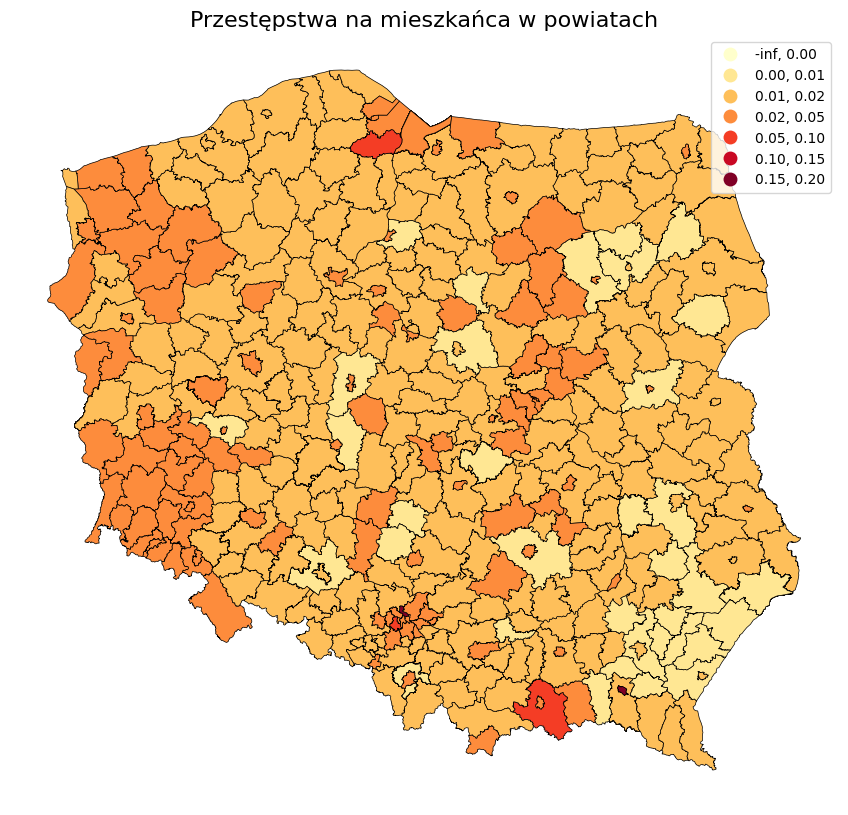

In [43]:
import matplotlib.pyplot as plt

# Przedziały dla własnego podziału
bins = [0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2]

# Rysowanie mapy
fig, ax = plt.subplots(1, 1, figsize=(12, 10))  # Rozmiar mapy
map_data.plot(
    column='Przestepstwa_średnia_powiaty',  # Kolumna z danymi
    cmap='YlOrRd',  # Paleta kolorów (możesz zmienić np. na 'coolwarm')
    linewidth=0.5,  # Grubość krawędzi powiatów
    edgecolor='black',  # Kolor krawędzi
    legend=True,  # Dodanie legendy
    scheme='UserDefined',  # Własny schemat klasyfikacji
    classification_kwds={'bins': bins},  # Określenie przedziałów (bins)
    ax=ax  # Osie
)

# Dostosowanie mapy
ax.set_axis_off()  # Wyłączenie osi
plt.title('Przestępstwa na mieszkańca w powiatach', fontsize=16)  # Tytuł mapy
plt.show()  # Wyświetlenie mapy





In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

map_data['Ceny mieszkan'] = scaler.fit_transform(map_data[['Ceny mieszkan']])
map_data['Bezrobotni_średnia_powiaty'] = scaler.fit_transform(map_data[['Bezrobotni_średnia_powiaty']])
map_data['Dochody na mieszkanca'] = scaler.fit_transform(map_data[['Dochody na mieszkanca']])
map_data['Wynagrodzenie'] = scaler.fit_transform(map_data[['Wynagrodzenie']])
map_data['Rozwody_średnia_powiaty'] = scaler.fit_transform(map_data[['Rozwody_średnia_powiaty']])

In [45]:
# map_data['Ceny mieszkan'] = np.log2(map_data[['Ceny mieszkan']])
# map_data['Bezrobotni_średnia_powiaty'] = np.log2(map_data[['Bezrobotni_średnia_powiaty']])
# map_data['Dochody na mieszkanca'] = np.log2(map_data[['Dochody na mieszkanca']])
# map_data['Wynagrodzenie'] = np.log2(map_data[['Wynagrodzenie']])
# map_data['Rozwody_średnia_powiaty'] = np.log2(map_data[['Rozwody_średnia_powiaty']])

Badanie autokorelacji przestrzennej

In [46]:
# Lista zmiennych do analizy
variables = [
    'Przestepstwa_średnia_powiaty',
    'Bezrobotni_średnia_powiaty',
    'Ceny mieszkan',
    'Dochody na mieszkanca',
    'Wynagrodzenie',
    'Rozwody_średnia_powiaty'
]

# Tworzenie wag przestrzennych
w = weights.Queen.from_dataframe(map_data)
w.transform = 'r'

# Iteracja przez zmienne
for data_column in variables:
    print(f"=== Statystyki przestrzenne dla zmiennej: {data_column} ===")
    
    # Moran's I
    moran = Moran(map_data[data_column], w)
    print("Moran's I:", moran.I)
    print("P-value (Moran's I):", moran.p_norm)
    
    # Geary's C
    geary = Geary(map_data[data_column], w)
    print("Geary's C:", geary.C)
    print("P-value (Geary's C):", geary.p_norm)
    
    # Global Getis-Ord G
    g = G(map_data[data_column], w)
    print("Getis-Ord G:", g.G)
    print("P-value (Getis-Ord G):", g.p_norm)
    
    # Local Getis-Ord G
    local_g = G_Local(map_data[data_column], w)
    print("Local Getis-Ord G Z-scores:", local_g.Zs[:5])  # Pokazanie pierwszych 5 wyników
    print("P-value (Local Getis-Ord G):", local_g.p_sim[:5])  # Pokazanie pierwszych 5 p-value

    print("\n")

C:\Users\xjulc\AppData\Local\Temp\ipykernel_74596\3209396215.py:12: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(map_data)


=== Statystyki przestrzenne dla zmiennej: Przestepstwa_średnia_powiaty ===
Moran's I: 0.08238914588075659
P-value (Moran's I): 4.645586728403748e-06
Geary's C: 0.8889326330816142
P-value (Geary's C): 1.4660144940122693e-07
Getis-Ord G: 0.024174778030003844
P-value (Getis-Ord G): 0.42646281114356566
Local Getis-Ord G Z-scores: [0.35854363 0.35854363 0.35854363 0.35854363 0.41098102]
P-value (Local Getis-Ord G): [0.069 0.069 0.069 0.069 0.052]


=== Statystyki przestrzenne dla zmiennej: Bezrobotni_średnia_powiaty ===
Moran's I: 0.3579618089431424
P-value (Moran's I): 8.434395446475488e-86
Geary's C: 0.6313018733535143
P-value (Geary's C): 2.816862371382608e-65
Getis-Ord G: -3.6189792315475353
P-value (Getis-Ord G): 0.0
Local Getis-Ord G Z-scores: [0.08839254 0.08839254 0.12625278 0.12625278 0.08839254]
P-value (Local Getis-Ord G): [0.299 0.299 0.251 0.251 0.298]


=== Statystyki przestrzenne dla zmiennej: Ceny mieszkan ===
Moran's I: 0.4446219316201523
P-value (Moran's I): 4.136586761418

Model regresji przestrzennej

Spatial Autoregressive Model (SAR)

In [47]:
from spreg import ML_Lag

# Model SAR
sar_model = ML_Lag(
    y=map_data['Przestepstwa_średnia_powiaty'].values,
    x=map_data[['Bezrobotni_średnia_powiaty', 'Ceny mieszkan', 'Dochody na mieszkanca', 'Wynagrodzenie', 'Rozwody_średnia_powiaty']].values,
    w=w,
    name_y='Przestepstwa_średnia_powiaty',
    name_x=['Bezrobotni_średnia_powiaty', 'Ceny mieszkan', 'Dochody na mieszkanca', 'Wynagrodzenie', 'Rozwody_średnia_powiaty']
)

summary_text = sar_model.summary

# Zamiana kropek na przecinki
summary_with_commas = summary_text.replace('.', ',')

# Wyświetlenie wyników z przecinkami
print(summary_with_commas)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Przestepstwa_średnia_powiaty                Number of Observations:         680
Mean dependent var  :      0,0195                Number of Variables   :           7
S,D, dependent var  :      0,0128                Degrees of Freedom    :         673
Pseudo R-squared    :      0,1852
Spatial Pseudo R-squared:  0,1681
Log likelihood      :   2069,3887
Sigma-square ML     :      0,0001                Akaike info criterion :   -4124,777
S,E of regression   :      0,0115                Schwarz criterion     :   -4093,123

------------------------------------------------------------------------------------
            Variable     Coefficient       Std,Error     z-Statistic     Probability
-----------------------------------------------

In [50]:
from scipy.stats import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan

# Reszty modelu SAR
residuals = sar_model.u  # Reszty modelu SAR

# Test Jarque-Bera dla normalności reszt
jb_stat, jb_pvalue = jarque_bera(residuals)
print(f"Test Jarque-Bera (normalność reszt): statystyka={jb_stat:.4f}, p-wartość={jb_pvalue:.4f}")

# Test Breuscha-Pagana dla heteroskedastyczności
bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals, sar_model.x)
print(f"Test Breuscha-Pagana (heteroskedastyczność): statystyka={bp_stat:.4f}, p-wartość={bp_pvalue:.4f}")


Test Jarque-Bera (normalność reszt): statystyka=126246.2747, p-wartość=0.0000
Test Breuscha-Pagana (heteroskedastyczność): statystyka=23.7306, p-wartość=0.0002


In [47]:
import numpy as np
from scipy.sparse import identity
from scipy.sparse.linalg import inv
from scipy.stats import chi2

e = sar_model.u

sigma2_hat = sar_model.sig2

W = w.sparse

rho_hat = sar_model.rho

n = W.shape[0]
I = identity(n, format='csr')

trace_term = np.sum(np.diag((W.T @ W + W.multiply(W)).todense()) @ inv(I - rho_hat * W).todense())

S_rho = np.sum(e * (W @ e)) / sigma2_hat
LM_SEM_SAR = (S_rho**2) / (len(e) - trace_term)

p_value = 1 - chi2.cdf(LM_SEM_SAR, df=1)

print(f"Statystyka LM SEM/SAR: {LM_SEM_SAR}")
print(f"Wartość p: {p_value}")


Statystyka LM SEM/SAR: 0.011728877954088467
Wartość p: 0.9137577667308814


c:\Python310\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
c:\Python310\lib\site-packages\scipy\sparse\linalg\_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Spatial Error Model (SEM)

In [48]:
from spreg import ML_Error

# Model SEM
sem_model = ML_Error(
    y=map_data['Przestepstwa_średnia_powiaty'].values,
    x=map_data[['Bezrobotni_średnia_powiaty', 'Ceny mieszkan', 'Dochody na mieszkanca', 'Wynagrodzenie', 'Rozwody_średnia_powiaty']].values,
    w=w,
    name_y='Przestepstwa_średnia_powiaty',
    name_x=['Bezrobotni_średnia_powiaty', 'Ceny mieszkan', 'Dochody na mieszkanca', 'Wynagrodzenie', 'Rozwody_średnia_powiaty']
)
print(sem_model.summary)


c:\Python310\lib\site-packages\spreg\ml_error.py:183: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Przestepstwa_średnia_powiaty                Number of Observations:         680
Mean dependent var  :      0.0195                Number of Variables   :           6
S.D. dependent var  :      0.0128                Degrees of Freedom    :         674
Pseudo R-squared    :      0.1642
Log likelihood      :   2068.5007
Sigma-square ML     :      0.0001                Akaike info criterion :   -4125.001
S.E of regression   :      0.0115                Schwarz criterion     :   -4097.869

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    

In [49]:
import numpy as np
from scipy.sparse import identity
from scipy.sparse.linalg import inv
from scipy.stats import chi2

e = sem_model.u

sigma2_hat = sem_model.sig2

W = w.sparse

lambda_hat = sem_model.lam

n = W.shape[0]
I = identity(n, format='csr')

trace_term = np.sum(np.diag((W.T @ W + W.multiply(W)).todense()) @ inv(I - lambda_hat * W).todense())

S_lambda = np.sum(e * (W @ e)) / sigma2_hat
LM_SEM = (S_lambda**2) / (len(e) - trace_term)

p_value = 1 - chi2.cdf(LM_SEM, df=1)

print(f"Statystyka LM SEM: {LM_SEM}")
print(f"Wartość p: {p_value}")


Statystyka LM SEM: [[3.77200162]]
Wartość p: [[0.05211723]]


c:\Python310\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
c:\Python310\lib\site-packages\scipy\sparse\linalg\_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


In [52]:
from spreg import ML_Lag

# Spatial Lag Model
slm_model = ML_Lag(
    y=map_data['Przestepstwa_średnia_powiaty'].values,
    x=map_data[['Bezrobotni_średnia_powiaty', 'Ceny mieszkan', 'Dochody na mieszkanca', 'Wynagrodzenie', 'Rozwody_średnia_powiaty']].values,
    w=w,
    name_y='Przestepstwa_średnia_powiaty',
    name_x=['Bezrobotni_średnia_powiaty', 'Ceny mieszkan', 'Dochody na mieszkanca', 'Wynagrodzenie', 'Rozwody_średnia_powiaty']
)

# Wyświetlenie wyników
print(slm_model.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Przestepstwa_średnia_powiaty                Number of Observations:         680
Mean dependent var  :      0.0195                Number of Variables   :           7
S.D. dependent var  :      0.0128                Degrees of Freedom    :         673
Pseudo R-squared    :      0.1852
Spatial Pseudo R-squared:  0.1681
Log likelihood      :   2069.3887
Sigma-square ML     :      0.0001                Akaike info criterion :   -4124.777
S.E of regression   :      0.0115                Schwarz criterion     :   -4093.123

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------

In [53]:
import numpy as np
from scipy.sparse import identity
from scipy.sparse.linalg import inv
from scipy.stats import chi2

e = slm_model.u

sigma2_hat = slm_model.sig2

W = w.sparse

rho_hat = slm_model.rho

n = W.shape[0]
I = identity(n, format='csr')

trace_term = np.sum(np.diag((W.T @ W + W.multiply(W)).todense()) @ inv(I - rho_hat * W).todense())

S_rho = np.sum(e * (W @ e)) / sigma2_hat
LM_SLM = (S_rho**2) / (len(e) - trace_term)

p_value = 1 - chi2.cdf(LM_SLM, df=1)

print(f"Statystyka LM SLM: {LM_SLM}")
print(f"Wartość p: {p_value}")


Statystyka LM SLM: 0.011728877954088467
Wartość p: 0.9137577667308814


c:\Python310\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
c:\Python310\lib\site-packages\scipy\sparse\linalg\_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


In [54]:
from spreg import ML_Error

# Model SEC (przybliżony do SEM)
sec_model = ML_Error(
    y=map_data['Przestepstwa_średnia_powiaty'].values,
    x=map_data[['Bezrobotni_średnia_powiaty', 'Ceny mieszkan', 'Dochody na mieszkanca', 'Wynagrodzenie', 'Rozwody_średnia_powiaty']].values,
    w=w,
    name_y='Przestepstwa_średnia_powiaty',
    name_x=['Bezrobotni_średnia_powiaty', 'Ceny mieszkan', 'Dochody na mieszkanca', 'Wynagrodzenie', 'Rozwody_średnia_powiaty']
)

print(sec_model.summary)


c:\Python310\lib\site-packages\spreg\ml_error.py:183: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Przestepstwa_średnia_powiaty                Number of Observations:         680
Mean dependent var  :      0.0195                Number of Variables   :           6
S.D. dependent var  :      0.0128                Degrees of Freedom    :         674
Pseudo R-squared    :      0.1642
Log likelihood      :   2068.5007
Sigma-square ML     :      0.0001                Akaike info criterion :   -4125.001
S.E of regression   :      0.0115                Schwarz criterion     :   -4097.869

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    

In [55]:
import numpy as np
from scipy.sparse import identity
from scipy.sparse.linalg import inv
from scipy.stats import chi2

e = sec_model.u

sigma2_hat = sec_model.sig2

W = w.sparse

lambda_hat = sec_model.lam

n = W.shape[0]
I = identity(n, format='csr')

trace_term = np.sum(np.diag((W.T @ W + W.multiply(W)).todense()) @ inv(I - lambda_hat * W).todense())

S_lambda = np.sum(e * (W @ e)) / sigma2_hat
LM_SEC = (S_lambda**2) / (len(e) - trace_term)

p_value = 1 - chi2.cdf(LM_SEC, df=1)

print(f"Statystyka LM SEC: {LM_SEC}")
print(f"Wartość p: {p_value}")


Statystyka LM SEC: [[3.77200162]]
Wartość p: [[0.05211723]]


c:\Python310\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
c:\Python310\lib\site-packages\scipy\sparse\linalg\_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


In [56]:
from spreg import OLS

#SCM model
scm_model = OLS(
    y=map_data['Przestepstwa_średnia_powiaty'].values,
    x=map_data[['Bezrobotni_średnia_powiaty', 'Ceny mieszkan', 'Dochody na mieszkanca', 'Wynagrodzenie', 'Rozwody_średnia_powiaty']].values,
    name_y='Przestepstwa_średnia_powiaty',
    name_x=['Bezrobotni_średnia_powiaty', 'Ceny mieszkan', 'Dochody na mieszkanca', 'Wynagrodzenie', 'Rozwody_średnia_powiaty']
)
print(scm_model.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :Przestepstwa_średnia_powiaty                Number of Observations:         680
Mean dependent var  :      0.0195                Number of Variables   :           6
S.D. dependent var  :      0.0128                Degrees of Freedom    :         674
R-squared           :      0.1654
Adjusted R-squared  :      0.1592
Sum squared residual:   0.0921606                F-statistic           :     26.7089
Sigma-square        :       0.000                Prob(F-statistic)     :   1.124e-24
S.E. of regression  :       0.012                Log likelihood        :    2063.269
Sigma-square ML     :       0.000                Akaike info criterion :   -4114.538
S.E of regression ML:      0.0116                Schwarz criterion     :   -4087.405

--------------------------------------------